# Create data

In [1]:
%cd ..

import os
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

from alignment.alignment_utils import load_aligned_model, load_deep_jscc
from utils import get_psnr, image_normalization

from dataset import Vanilla
from model import DeepJSCC
from tqdm import tqdm
import pickle

d:\File\Repos\Deep-JSCC-PyTorch


In [2]:
model1_fp = r'alignment\models\upscaled_42.pkl'
model2_fp = r'alignment\models\upscaled_43.pkl'
saved = r'out\checkpoints\CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025\epoch_999.pkl'
snr = 7

dataset = "cifar10"
batch_size = 64
num_workers = 4
channel = 'AWGN'

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
############
# GET DATA #
############

if dataset == 'cifar10':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64))])

    train_dataset = datasets.CIFAR10(root='../dataset/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.CIFAR10(root='../dataset/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenet':
    # the size of paper is 128
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])

    print("loading data of imagenet")

    train_dataset = datasets.ImageFolder(root='./dataset/ImageNet/train', transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = Vanilla(root='./dataset/ImageNet/val', transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenette':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])

    train_dataset = datasets.Imagenette(root='../dataset/', split="train", download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.Imagenette(root='../dataset/', split="val", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

else:
    raise Exception('Unknown dataset')

In [4]:
def load_from_checkpoint(path, snr):
    state_dict = torch.load(path, map_location=device)
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k.replace('module.','') # remove `module.`
        new_state_dict[name] = v

    file_name = os.path.basename(os.path.dirname(saved))
    c = file_name.split('_')[1]
    c = int(c)
    model = DeepJSCC(c=c, channel_type=channel, snr=snr)

    model.load_state_dict(new_state_dict)
    model.change_channel(channel, snr)

    return model

model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

In [5]:
class AlignmentDataset(Dataset):
    def __init__(self, dataloader, model1, model2):
        self.outputs = []

        model1.eval()
        model1.to(device)

        model2.eval()
        model2.to(device)

        with torch.no_grad():
            for inputs, _ in tqdm(dataloader, desc="Computing model outputs"):
                inputs = inputs.to(device)

                out1 = model1(inputs)
                out2 = model2(inputs)

                for o1, o2 in zip(out1, out2):
                    o1 = o1.flatten()
                    o2 = o2.flatten()
                    self.outputs.append((o1.cpu(), o2.cpu()))

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return self.outputs[idx]

In [6]:
# 50.000 (samples) / 64 (batch size) = 781.25 -> 782 (batches to compute) 
data = AlignmentDataset(train_loader, model1, model2)

Computing model outputs: 100%|██████████| 782/782 [00:35<00:00, 22.02it/s]


# Train model

## Least Squares

In [7]:
def dataset_to_matrices(dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    data_1 = []
    data_2 = []
    
    for batch in loader:
        data_1.append(batch[0])
        data_2.append(batch[1])

    return torch.cat(data_1, dim=0), torch.cat(data_2, dim=0)

matrix_1, matrix_2 = dataset_to_matrices(data)

In [8]:
#################
# LEAST SQUARES #
#################

Y = matrix_1.T
Z = matrix_2.T

Q = Y @ Z.T @ torch.inverse(Z @ Z.T)

with open(r'alignment\models\aligner_upscaled.pkl', 'wb') as f:
    pickle.dump(Q, f)

In [31]:
##############
# VALIDATION #
##############

channel = 'AWGN'
model1_fp = r'alignment\models\seed42_v1.pkl'
model2_fp = r'alignment\models\seed43_v1.pkl'
aligner_fp = r'alignment\models\aligner_small.pkl'
saved = r'out\checkpoints\CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025\epoch_999.pkl'

snr = 7
times = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

file_name = os.path.basename(os.path.dirname(saved))
c = file_name.split('_')[1]
c = int(c)

model1 = load_deep_jscc(model1_fp, snr, c, channel)
unaligned_model = load_aligned_model(model1_fp, model2_fp, None, snr, c, channel)
aligned_model = load_aligned_model(model1_fp, model2_fp, aligner_fp, snr, c, channel)

In [41]:
def get_batch_psnr(images, gts, max_val=255):
    # assumes shape: (B, C, H, W)
    batch_mse = F.mse_loss(images, gts, reduction='none')
    batch_mse = batch_mse.view(batch_mse.size(0), -1).mean(dim=1)  # mean over each image
    psnr = 10 * torch.log10(max_val**2 / batch_mse)
    return psnr  # shape: (B,)

def validation(model, dataloader, times):

    model = model.to(device)
    batch_psnr_list = []

    with torch.no_grad():
        for inputs, _ in dataloader:

            inputs = inputs.to(device)
            psnr = torch.zeros(size=(inputs.shape[0], ), device=device)

            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                gt = image_normalization('denormalization')(inputs)
                psnr += get_batch_psnr(demo_image, gt)

            psnr /= times
            batch_mean_psnr = psnr.mean().item()
            batch_psnr_list.append(batch_mean_psnr)

    overall_mean_psnr = sum(batch_psnr_list) / len(batch_psnr_list)

    return overall_mean_psnr

In [27]:
validation(model1, test_loader, times)

Computing validation: 100%|██████████| 157/157 [00:22<00:00,  6.90it/s]


Overall validation PSNR: 22.74


In [28]:
validation(unaligned_model, test_loader, times)

Computing validation: 100%|██████████| 157/157 [00:22<00:00,  7.01it/s]


Overall validation PSNR: 10.39


In [6]:
validation(aligned_model, test_loader, times)

Computing validation: 100%|██████████| 157/157 [00:23<00:00,  6.82it/s]


Overall validation PSNR: 27.90


In [42]:
def dataset_to_matrices(dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    data_1 = []
    data_2 = []
    i = 0
    for batch in loader:
        data_1.append(batch[0])
        data_2.append(batch[1])
        i += 1

        if i == 10:
            break

    return torch.cat(data_1, dim=0), torch.cat(data_2, dim=0)

matrix_1, matrix_2 = dataset_to_matrices(data)

def increasing_dataset_size():
    batch_size = 128
    n_batches = 782
    times = 10

    for b in range(1, n_batches+1):

        # dataset to matrices
        loader = DataLoader(data, batch_size=batch_size, shuffle=False)
        data_1 = []
        data_2 = []

        i = 0
        for batch in loader:
            data_1.append(batch[0])
            data_2.append(batch[1])
            i += 1

            if i == b:
                break

        matrix_1 = torch.cat(data_1, dim=0)
        matrix_2 = torch.cat(data_2, dim=0)

        # get model
        Y = matrix_1.T
        Z = matrix_2.T

        Q = Y @ Z.T @ torch.inverse(Z @ Z.T)

        with open(r'alignment\models\aligner_small.pkl', 'wb') as f:
            pickle.dump(Q, f)

        # load aligned model
        aligned_model = load_aligned_model(model1_fp, model2_fp, aligner_fp, snr, c, channel)

        print(f"For {b} batches we get a PSNR of {validation(aligned_model, test_loader, times):.2f}")

In [43]:
increasing_dataset_size()

For 1 batches we get a PSNR of 5.22
For 2 batches we get a PSNR of 5.37
For 3 batches we get a PSNR of 5.15
For 4 batches we get a PSNR of 5.26
For 5 batches we get a PSNR of 5.38
For 6 batches we get a PSNR of 5.14
For 7 batches we get a PSNR of 5.36
For 8 batches we get a PSNR of 6.40
For 9 batches we get a PSNR of 18.09
For 10 batches we get a PSNR of 21.53
For 11 batches we get a PSNR of 23.44
For 12 batches we get a PSNR of 24.43
For 13 batches we get a PSNR of 25.09
For 14 batches we get a PSNR of 25.57
For 15 batches we get a PSNR of 25.88
For 16 batches we get a PSNR of 26.14
For 17 batches we get a PSNR of 26.33
For 18 batches we get a PSNR of 26.50
For 19 batches we get a PSNR of 26.63
For 20 batches we get a PSNR of 26.74
For 21 batches we get a PSNR of 26.84
For 22 batches we get a PSNR of 26.90
For 23 batches we get a PSNR of 26.97
For 24 batches we get a PSNR of 27.03
For 25 batches we get a PSNR of 27.08
For 26 batches we get a PSNR of 27.13
For 27 batches we get a PSNR 

KeyboardInterrupt: 

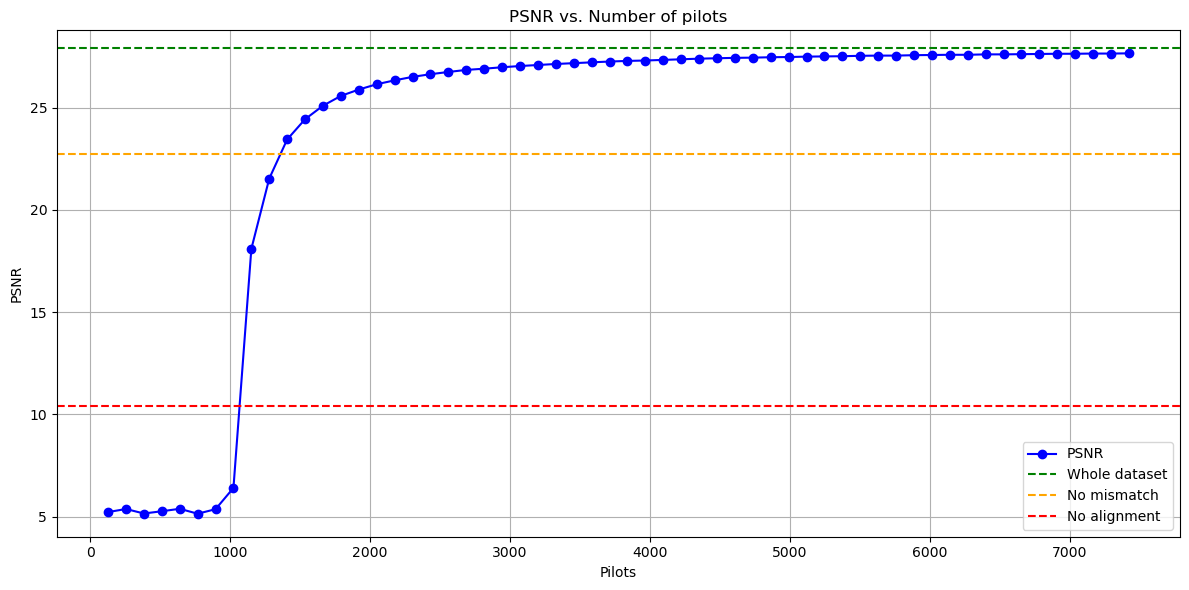

In [14]:
import matplotlib.pyplot as plt

psnr_values = [
    5.22, 5.37, 5.15, 5.26, 5.38, 5.14, 5.36, 6.40, 18.09, 21.53,
    23.44, 24.43, 25.09, 25.57, 25.88, 26.14, 26.33, 26.50, 26.63, 26.74,
    26.84, 26.90, 26.97, 27.03, 27.08, 27.13, 27.17, 27.21, 27.25, 27.28,
    27.30, 27.33, 27.36, 27.39, 27.41, 27.43, 27.44, 27.46, 27.47, 27.49,
    27.50, 27.51, 27.53, 27.54, 27.54, 27.56, 27.57, 27.58, 27.58, 27.60,
    27.60, 27.61, 27.62, 27.63, 27.63, 27.64, 27.64, 27.65
]

batches = list(range(1, len(psnr_values) + 1))

# Convert batches to number of elements (batch size = 128)
elements = [batch * 128 for batch in batches]

# Plotting with elements instead of batches
plt.figure(figsize=(12, 6))
plt.plot(elements, psnr_values, marker='o', linestyle='-', color='b', label='PSNR')

# Adding horizontal lines
plt.axhline(y=27.90, color='g', linestyle='--', linewidth=1.5, label='Whole dataset')
plt.axhline(y=22.74, color='orange', linestyle='--', linewidth=1.5, label='No mismatch')
plt.axhline(y=10.39, color='red', linestyle='--', linewidth=1.5, label='No alignment')

# Titles and labels
plt.title('PSNR vs. Number of pilots')
plt.xlabel('Pilots')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Neural

In [9]:
#############################
# LINEAR MODEL SGD TRAINING #
#############################

X = matrix_1
Y = matrix_2

# define linear model
model = nn.Linear(1024, 1024, bias=True)

# define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
num_epochs = 1000
for epoch, _ in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

# get the weight and bias
weights = model.weight.data   # shape: [1024, 1024]
bias = model.bias.data        # shape: [1024]

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable int object